#Assignment 2: Fitting Data and Chemometrics

In [16]:
"""
This cell contains code for loading the pyMCr module used in the notebook as 
well as importing data used. This cell has to be run once everytime the notebook
is started up and will give errors ('fatal: ..') when run multiple times.
"""

import os
!git clone https://github.com/usnistgov/pyMCR.git

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
os.chdir("pyMCR/")
from pymcr.regressors import OLS, NNLS
from pymcr.constraints import ConstraintNonneg, ConstraintNorm
import sys
import logging

"Preamble required for Mcr-AR to work:"
from pymcr.mcr import McrAR
logger = logging.getLogger('pymcr')
logger.setLevel(logging.DEBUG)
stdout_handler = logging.StreamHandler(stream=sys.stdout)
stdout_format = logging.Formatter('%(message)s')  
stdout_handler.setFormatter(stdout_format)
logger.addHandler(stdout_handler)
os.chdir("..")

#Importing data
!git clone https://github.com/andysardjan/data-for-topics-in-chemistry-with-python.git

fatal: destination path 'pyMCR' already exists and is not an empty directory.
fatal: destination path 'data-for-topics-in-chemistry-with-python' already exists and is not an empty directory.


#Least Squares Fitting

This assignment has two parts, in the first part we are going the estimate molar absorbances from data. In the second part we are going to analyse kinetic data using multivariate curve resolution.

First we are going to calculate Molar absorbances of a complex called copper phthalocyanine.
You can load in the data using dat = pd.read_csv('filename.csv'). Then you can get the concentrations use dat['Cu_10uM'] to get the absorbance data for the 10 uM sample.

In [17]:
datCu = pd.read_csv('data-for-topics-in-chemistry-with-python/cu_dat.dat', delimiter = '\t')

You can inspect the loaded data when just running the variable name itself:

In [18]:
datCu

,Wavelength [nm],Wavenumbers [1/cm],Cu_10uM,"Cu_12,5uM",Cu_25uM,Cu_50uM,Cu_5uM
0,183.0,54644.81,0.18860,0.205300,0.299000,0.19860,0.22440
1,183.5,54495.91,0.10690,-0.053620,0.133300,0.07198,0.02128
2,184.0,54347.83,-0.00850,-0.147800,-0.019470,-0.07377,-0.02258
3,184.5,54200.54,-0.04847,-0.013470,-0.023280,-0.10830,0.12500
4,185.0,54054.05,-0.01226,0.125200,0.101200,-0.05022,0.11370
...,...,...,...,...,...,...,...
1669,1017.5,9828.01,0.04374,0.001273,0.006675,0.02255,0.03686
1670,1018.0,9823.18,0.04512,0.002456,0.012470,0.01901,0.03794
1671,1018.5,9818.36,0.04969,0.008075,0.015360,0.02125,0.04092
1672,1019.0,9813.54,0.05452,0.010640,0.016600,0.02563,0.04394


You can get the data out using the names of the columns, for example datCu['Wavelength [nm]'] returns the wavelength data, and datCu['Cu_10uM'] returns the data for 10 $\mu$M. 

# Plotting
Make two plots of the all the given data (datCu all conccentrations), part of the code is given allready, each plot should contain all the different concentration data and have proper labels 


# Fitting
Now we will do fitting on the absorbance peak values to calculate molar absorbances. According to the Lambert-Beer law:
$$
A_\lambda = \epsilon_\lambda c l
$$
We should be able to calculate $\epsilon_\lambda$ at a particular wavelength, using the absorbances and concentrations. The datasets given have the concentrations in the column names, and the pathlengths (l) is always 1 cm. So by doing a linear fit: $y = ax$, where y is the absorbance values, x the concentrations and the slope a should be the molar absorbance then. To fit the function we first have to get out the correct absorbance values. We can get certain values out of a dataframe using the indices, example:

In [19]:
datCu[0:5]

,Wavelength [nm],Wavenumbers [1/cm],Cu_10uM,"Cu_12,5uM",Cu_25uM,Cu_50uM,Cu_5uM
0,183.0,54644.81,0.18860,0.20530,0.29900,0.19860,0.22440
1,183.5,54495.91,0.10690,-0.05362,0.13330,0.07198,0.02128
2,184.0,54347.83,-0.00850,-0.14780,-0.01947,-0.07377,-0.02258
3,184.5,54200.54,-0.04847,-0.01347,-0.02328,-0.10830,0.12500
4,185.0,54054.05,-0.01226,0.12520,0.10120,-0.05022,0.11370


This gives the first 5 data points for all the columns, we want to find the absorbance values around a peak. Using the graphs above we can estimate that one of the maxima is around 350 nm, so by trial and error we do:

In [20]:
datCu[300:310]

,Wavelength [nm],Wavenumbers [1/cm],Cu_10uM,"Cu_12,5uM",Cu_25uM,Cu_50uM,Cu_5uM
300,333.0,30030.03,0.2506,0.4923,0.9567,1.885,0.1303
301,333.5,29985.01,0.2512,0.4938,0.9638,1.864,0.1317
302,334.0,29940.12,0.2519,0.4944,0.9633,1.874,0.1315
303,334.5,29895.37,0.2525,0.4951,0.9617,1.901,0.1314
304,335.0,29850.75,0.2528,0.4962,0.9672,1.911,0.1329
305,335.5,29806.26,0.2527,0.4961,0.9685,1.909,0.1336
306,336.0,29761.90,0.2526,0.4954,0.9633,1.904,0.1326
307,336.5,29717.68,0.2526,0.4972,0.9629,1.903,0.1317
308,337.0,29673.59,0.2527,0.4986,0.9674,1.896,0.1315
309,337.5,29629.63,0.2524,0.4959,0.9704,1.874,0.1316


We have to find a range where all the (local) maxima are, then we can use the .max() method to get out the maxima themselves:


In [21]:
datCu[300:310].max()

Wavelength [nm]         337.5000
Wavenumbers [1/cm]    30030.0300
Cu_10uM                   0.2528
Cu_12,5uM                 0.4986
Cu_25uM                   0.9704
Cu_50uM                   1.9110
Cu_5uM                    0.1336
dtype: float64

Next we can get out the maxima by removing the wavelength and wavenumbers data:
We can also make the concentration list from the labels.

In [22]:
y = datCu[300:310].max()[2:] #this gets indices 300 untill 310 from dataCo (which is 333 nm to 337.5 nm), then gets the maxima of the absorbances
x = [10E-6, 12.5E-6, 25E-6, 50E-6, 5E-6] # the concentrations

Next we plot just the absorbance maximum data versus concentration:

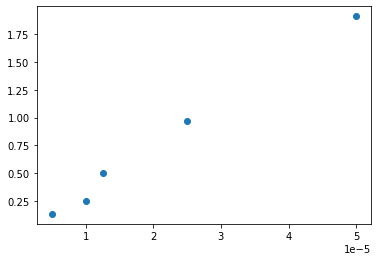

In [23]:
plt.plot(x, y, 'o')

Looks (more or less) linear! Now we still have to do the fit. We can use the scipy.optimize.curve_fit() method. If we look at the documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

We need to fill in: (f, xdata, ydata) where f is the function we want to use to fit the data. Define a linear function based on the lambert-Beer law and fit the data, also plot the result together with the data to see if the fit was succesfull. Note that the pathlengs for all these experiments is 1 cm.

In [24]:
def linear(x, a):
  return(a*x)
fit = curve_fit(linear, x, y)[0]
fit

array([37941.57798165])

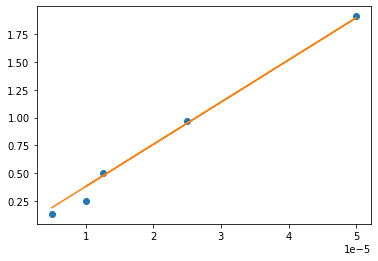

In [25]:
plt.plot(x, y, 'o')
plt.plot(x, linear(x, fit))

Now we have calculated the molar absorbance for Cu at 340 nm, do the same for the other peak for Cu and the peaks.

#Baselining Data
As you might have noticed, the absorbances are not exactly linear with concenration. Also in the plot of all the different concnetrations is can be seen that we have a baseline problem i.e. the different datasets do not have the sample zero-absorbance. We can fix this by taking an average value from the data between 800 nm - 900 nm (where there is no absorbance, and subtracting this from the rest of the data), we can make a new baselines dataset using:

In [26]:
datCu_baselined = datCu - 0#somethinghere #subracts the baselines from data points 1150:1200 from each set. 
datCu_baselined

,Wavelength [nm],Wavenumbers [1/cm],Cu_10uM,"Cu_12,5uM",Cu_25uM,Cu_50uM,Cu_5uM
0,183.0,54644.81,0.18860,0.205300,0.299000,0.19860,0.22440
1,183.5,54495.91,0.10690,-0.053620,0.133300,0.07198,0.02128
2,184.0,54347.83,-0.00850,-0.147800,-0.019470,-0.07377,-0.02258
3,184.5,54200.54,-0.04847,-0.013470,-0.023280,-0.10830,0.12500
4,185.0,54054.05,-0.01226,0.125200,0.101200,-0.05022,0.11370
...,...,...,...,...,...,...,...
1669,1017.5,9828.01,0.04374,0.001273,0.006675,0.02255,0.03686
1670,1018.0,9823.18,0.04512,0.002456,0.012470,0.01901,0.03794
1671,1018.5,9818.36,0.04969,0.008075,0.015360,0.02125,0.04092
1672,1019.0,9813.54,0.05452,0.010640,0.016600,0.02563,0.04394


Make a new plot based on this data set and do the fitting analysis again does this make the fits better? Take the wavelength data from the original datCu dataset, as it is also 'baselined' in the line above. 

# Chemometrics
To convert kinetic data to concentration traces, we will use the python module 'pyMCR', it should allready be loaded and set up for you in the first cell of this notebook. A short explination of the method is given in the introductory document. The method requires, kinetic data and initial gueses of either the concentration traces or the spectra of the pure compounds. It is often easiest to use guesses for the spectra of the pure compounds First let's plot the data to get a feeling what is happening. There should be 121 UV-Vis absorption spectra given, so lets plot the data to see what is going on:


In [27]:
MCR_dat = np.genfromtxt('data-for-topics-in-chemistry-with-python/MCR_data.dat', skip_header=1)
x = MCR_dat[:,0]
ys = MCR_dat[:,2:].T




Another handy way of looking at this type of data is using a heatmap, make a heatmap using plt.imshow() https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.imshow.html the data 'ys' is given in the correct format allready. Give the plot a colorbar, and give the axes proper labels.


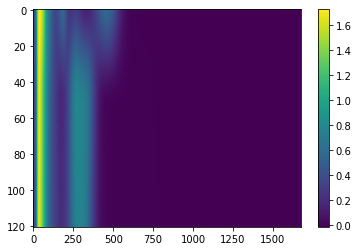

In [28]:
plt.imshow(ys, aspect = 'auto')
plt.colorbar()
plt.show()

# Multivariate Curve Resolution
Now let's analyse the data using chemometrics and see if we can figure out what is going on. We will first try using a two component fit, using the initial and final spectra as initial gueses. The module can be used in the following way. First you need to input settings for the method:
&nbsp;

&nbsp;

mcrar = McrAR(max_iter=1000,  tol_increase=10, tol_err_change=1e-10,st_regr=NNLS(), c_regr=OLS(),
              c_constraints=[ConstraintNonneg()])
&nbsp;

&nbsp;


This is given in the cell below in code and you shouldn't have to change these settings. Next the fitting procedure is started by using:

&nbsp;

mcrar.fit(Data, ST = array_of_intial_guesses)

&nbsp;

Where ST is an array of the initial guesses for spectra. The Data should be in a format of [spectrum 1, spectrum 2 , ..., final spectra] (as ys is allready). If ST contains two spectra, then the fitting assumes a two component fit. If three components are used then it does a three component fit (etc.). To start out is if good to start with a two component fit where the initial guesses are close to spectra for the pure compounds (think of which spectra would be good to use). Do this two component fit to the data. After the analysis is done, (it will output 'exiting'), then you can get out the optimized concentrations using mcrar.C_opt_, and the optimized component spectra using mcrar.ST_opt_.T



In [29]:
mcrar = McrAR(max_iter=1000,  tol_increase=10, tol_err_change=1e-10,st_regr=NNLS(), c_regr=OLS(),
              c_constraints=[ConstraintNonneg()]) #initialization of McrAR which reasonable settings

#initial_guesses = np.array([ , ]) #has to given as an np.array([guess 1, guess 2])

mcrar.fit(ys, ST = initial_guesses)


NameError: ignored

In [ ]:
#simple plotting of results
plt.plot(mcrar.C_opt_)
plt.show()
plt.plot(x, mcrar.ST_opt_.T)
plt.show()

# Analysing results
If everything went well, then a plot of mcrar.C_opt_ can be interpreted as an approximation of the real kinetic traces of the concentrations of species in an experiment. However when doing a fit to data, you always have to look at the residuals (how far the fit is away from the data). You can calculate the fitted spectra using:
&nbsp;

&nbsp;

predicted = np.dot(mcrar.C_opt_, mcrar.ST_opt_)

&nbsp;

&nbsp;

This might look complicated, but it essentialy the product of the concentrations times the corresponding spectra, at each time component. So intially it might take component 1 * 1 + component 2 * 0. The residuals are given then by:

&nbsp;

residuals = predicted - ys

&nbsp;

Analyse the residuals using a heatmap or sum of squared errors accross one axis (np.sum(residuals**2, axis = 0)) to get the total residual spectrum. (Tip: for the heatmap, use a colormap (cmap) that is diverging i.e. zero is white, look at: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)





# Analysing Residuals
If the fitting is adaquate (i.e. the model is complicated enough the explain the data), then the residuals should have little to no structure, i.e. it should look like random noise distributed at ~0. If there is structure in the residuals above, then add one more component and look at the residuals, are they more random now? Also look at the concntration traces, what sort of mechanism could explain this data?

Hint, if you look through the data carefully you should to be able to find a good guess for a third component spectrum

# Effect of pre-processing
For UV-Vis absorption spectroscopy, there is often no information obtainable if the absorbance is above ~1. There is a UV-absorbtion in the data which is due to solvent (not the sample) absorbing, there is also no information in the data when the absorbances are 0. So for the analysis it is smart to remove the UV peak and data beyonf 550 nm before doing the MCR. We also see a large residual in these areas. See what the effect is of removing the UV peak and repeating the analyses, does this change the results significantly?